In [1]:
import os
import numpy as np
import librosa as lb
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RAW_DIR = os.environ.get('RAW_AUDIO')
print(RAW_DIR)


C:\Users\bmp09\AUDIO_DIR\fma_small


In [3]:
def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    print(tid_str)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [4]:
tids = get_tids_from_directory(str(RAW_DIR))
print(len(tids))

8000


### Function to create spectograms

In [5]:
def create_spectogram_A(track_id):
    filename = get_audio_path(RAW_DIR, track_id)
    y, sr = lb.load(str(filename))
#     print(sr)
    A = y[:len(y)//2]
#     B = y[len(y)//2:]
#     print(len(y))
    spect = lb.feature.melspectrogram(y=A, sr=sr,n_fft=2048, hop_length=512)
    spect = lb.power_to_db(spect, ref=np.max)
    return spect.T

In [6]:
def create_spectogram_B(track_id):
    filename = get_audio_path(RAW_DIR, track_id)
    y, sr = lb.load(str(filename))
#     print(sr)
#     A = y[:len(y)//2]
    B = y[len(y)//2:]
#     print(len(y))
    spect = lb.feature.melspectrogram(y=B, sr=sr,n_fft=2048, hop_length=512)
    spect = lb.power_to_db(spect, ref=np.max)
    return spect.T

In [7]:
def plot_spect(track_id,gram):
    if (gram == 'A'):
        spect = create_spectogram_A(track_id)
    else:
        spect = create_spectogram_B(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

000005
(647, 128)


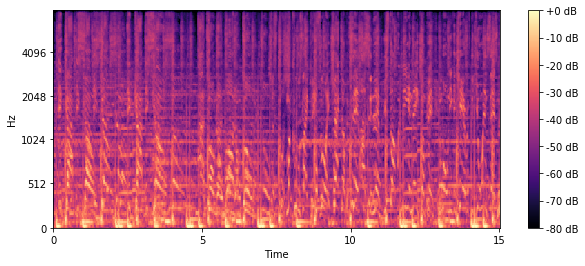

In [8]:
plot_spect(5,'A')

### Load dataset with genre and track IDs

In [9]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')

filepath = os.path.join(AUDIO_DIR,'fma_metadata','tracks.csv')


# filepath = 'audio_files/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top'),('artist','name'),('track','title')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

set            track                           artist  \
             split subset genre_top                             name   
track_id                                                               
2         training  small   Hip-Hop                             AWOL   
5         training  small   Hip-Hop                             AWOL   
10        training  small       Pop                        Kurt Vile   
140       training  small      Folk  Alec K. Redfearn & the Eyesores   
141       training  small      Folk  Alec K. Redfearn & the Eyesores   

                       track track_id  
                       title           
track_id                               
2                       Food        2  
5                 This World        5  
10                   Freeway       10  
140       Queen Of The Wires      140  
141                     Ohio      141

In [10]:
df_all.shape

(8000, 6)

In [11]:
df_all[('track', 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [12]:
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

### Create Arrays

In [13]:
def create_array(df):
    genres = []
    artist = []
    title = []
    X_spect= np.empty((0, 640, 128))
    
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            art = str(row[('artist','name')])
            til = str(row[('track','title')])
            
            
            spect_A = create_spectogram_A(track_id)
            spect_B = create_spectogram_B(track_id)


            # Normalize for small shape differences
            spect_A = spect_A[:640, :]
            spect_B = spect_B[:640, :]
            X_spect = np.append(X_spect, [spect_A], axis=0)
            genres.append(dict_genres[genre])
            artist.append(art)
            title.append(til)
            X_spect = np.append(X_spect, [spect_B], axis=0)
            genres.append(dict_genres[genre])
            artist.append(art)
            title.append(til)
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    art_title = np.array((artist,title))
    return X_spect, y_arr,art_title

In [14]:
df_all[('set', 'split')].unique()

array(['training', 'validation', 'test'], dtype=object)

### Create train, validation and test subsets

In [15]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 6) (800, 6) (800, 6)


In [16]:
X_test, y_test, z_test_art_titles = create_array(df_test)

000182
000182
000704
000704
000705
000705
000706
000706
000707
000707
000708
000708
000709
000709
000890
000890
000892
000892
001066
001066
001069
001069
001073
001073
001075
001075
001249
001249
001259
001259
003624
003624
004108
004108
007373
007373
007374
007374
007375
007375
007376
007376
007377
007377
007378
007378
007379
007379
007381
007381
007383
007383
007385
007385
007386
007386
007388
007388
007391
007391
007393
007393
009155
009155
010250
010250
010381
010381
010382
010382
010383
010383
010384
010384
010385
010385
010386
010386
010387
010387
010388
010388
010389
010389
010438
010438
010439
010439
010440
010440
010441
010441
010442
010442
010443
010443
010444
010444
010447
010447
010480
010480
010481
010481
010485
010485
010678
010678
010679
010679
010682
010682
010684
010684
010992
010992
010993
010993
011019
011019
011020
011020
011059
011059
011200
011200
011204
011204
011503
011503
011504
011504
011505
011505
011508
011508
012045
012045
012046
012046
012047
012047
012048

114976
114976
115002
115002
115011
115011
115176
115176
115288
115288
115289
115289
115290
115290
115292
115292
115293
115293
115294
115294
115926
115926
116175
116175
116176
116176
116177
116177
116388
116388
116389
116389
116390
116390
116407
116407
116526
116526
116527
116527
116528
116528
117251
117251
117252
117252
117253
117253
Currently processing:  600
117626
117626
117883
117883
117884
117884
117885
117885
117886
117886
117887
117887
117943
117943
117961
117961
118505
118505
119584
119584
119592
119592
119828
119828
119830
119830
119831
119831
120206
120206
121415
121415
121595
121595
121913
121913
121915
121915
121922
121922
121926
121926
121929
121929
121930
121930
121998
121998
122106
122106
122107
122107
122143
122143
122155
122155
122168
122168
122510
122510
122511
122511
124184
124184
124185
124185
124186
124186
124391
124391
124392
124392
124393
124393
124394
124394
126240
126240
126241
126241
126242
126242
126243
126243
126507
126507
127180
127180
127181
127181
127182


In [17]:
print(X_test.shape, y_test.shape,z_test_art_titles.shape)

(1600, 640, 128) (1600,) (2, 1600)


In [18]:
print(X_test[:1])

[[[-23.74448755 -23.76274032 -18.04612019 ... -80.         -80.
   -80.        ]
  [-24.77380277 -21.04284451 -13.19522668 ... -80.         -80.
   -80.        ]
  [-28.45256636 -21.40627147 -13.53550578 ... -80.         -80.
   -80.        ]
  ...
  [-20.21675664 -18.40994911 -17.32923942 ... -71.68970625 -75.90209112
   -80.        ]
  [-22.94539893 -17.2241193  -16.17382631 ... -73.35914908 -77.61784716
   -80.        ]
  [-28.50797059 -21.71692834 -19.37334089 ... -80.         -80.
   -80.        ]]]


In [19]:
np.savez('half640_test_arr', X_test, y_test,z_test_art_titles)

In [20]:
X_valid, y_valid,z_test_art_titles = create_array(df_valid)

000148
000148
000459
000459
000602
000602
000690
000690
000993
000993
001087
001087
001893
001893
002012
002012
003263
003263
003264
003264
003265
003265
003266
003266
004022
004022
005191
005191
006331
006331
006333
006333
006358
006358
006363
006363
006368
006368
006372
006372
006376
006376
006380
006380
006385
006385
006390
006390
006461
006461
006463
006463
006467
006467
006762
006762
006779
006779
006782
006782
006783
006783
007011
007011
009550
009550
009553
009553
009555
009555
009557
009557
009559
009559
009560
009560
011803
011803
012188
012188
012526
012526
012527
012527
013201
013201
013474
013474
013556
013556
013591
013591
014315
014315
014316
014316
014317
014317
014318
014318
014319
014319
014320
014320
014363
014363
014365
014365
014391
014391
014869
014869
015769
015769
015770
015770
015771
015771
015772
015772
015773
015773
016895
016895
017344
017344
017345
017345
018037
018037
018038
018038
018039
018039
019673
019673
019674
019674
019689
019689
020818
020818
021565

122356
122356
122357
122357
122358
122358
122359
122359
122360
122360
122362
122362
122363
122363
122364
122364
122365
122365
122456
122456
122457
122457
122832
122832
123490
123490
123494
123494
123501
123501
123502
123502
123503
123503
124201
124201
124517
124517
124518
124518
124519
124519
124891
124891
124892
124892
125154
125154
Currently processing:  600
125156
125156
125157
125157
125158
125158
125159
125159
125160
125160
125161
125161
125237
125237
125238
125238
125239
125239
125240
125240
125999
125999
126292
126292
126506
126506
126516
126516
126550
126550
126557
126557
126559
126559
126584
126584
126585
126585
126586
126586
126587
126587
126588
126588
126589
126589
126773
126773
127532
127532
127541
127541
127542
127542
127865
127865
127866
127866
127867
127867
127868
127868
127869
127869
127870
127870
127871
127871
127936
127936
128484
128484
128758
128758
128759
128759
128760
128760
129048
129048
129049
129049
129051
129051
129052
129052
129053
129053
129054
129054
129055


In [21]:
np.savez('half640_valid_arr', X_valid, y_valid)

#### Note: Train data split into 4 chunks to do the slow pre-processing in phases

In [16]:
def splitDataFrameIntoSmaller(df, chunkSize = 1600): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [17]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 6) (1600, 6) (1600, 6) (1600, 6)


In [18]:
X_train1, y_train1,z_test_art_titles = create_array(df1_train)

000002
000002
000005
000005
000010
000010
000140
000140
000141
000141
000190
000190
000193
000193
000194
000194
000197
000197
000200
000200
000203
000203
000204
000204
000207
000207
000210
000210
000211
000211
000212
000212
000213
000213
000255
000255
000256
000256
000368
000368
000424
000424
000534
000534
000540
000540
000546
000546
000574
000574
000615
000615
000620
000620
000621
000621
000625
000625
000666
000666
000667
000667
000676
000676
000694
000694
000695
000695
000714
000714
000715
000715
000716
000716
000718
000718
000777
000777
000814
000814
000821
000821
000822
000822
000825
000825
000853
000853
000897
000897
000995
000995
000997
000997
000998
000998
001039
001039
001040
001040
001082
001082
001083
001083
001102
001102
001193
001193
001195
001195
001196
001196
001197
001197
001270
001270
001276
001276
001277
001277
001278
001278
001417
001417
001427
001427
001443
001443
001482
001482
001510
001510
001544
001544
001642
001642
001644
001644
001649
001649
001661
001661
001663

017132
017132
017462
017462
017491
017491
017496
017496
017499
017499
017500
017500
017573
017573
017588
017588
017605
017605
017606
017606
017607
017607
017608
017608
017609
017609
017610
017610
017611
017611
017631
017631
017632
017632
017633
017633
017634
017634
017635
017635
017636
017636
017637
017637
017644
017644
017735
017735
Currently processing:  600
017782
017782
017884
017884
017906
017906
018031
018031
018032
018032
018033
018033
018034
018034
018043
018043
018044
018044
018124
018124
018144
018144
018145
018145
018146
018146
018159
018159
018197
018197
018607
018607
018611
018611
018876
018876
018877
018877
018887
018887
019073
019073
019074
019074
019179
019179
019184
019184
019187
019187
019192
019192
019412
019412
019413
019413
019415
019415
019416
019416
019417
019417
019418
019418
019420
019420
019422
019422
019423
019423
019425
019425
019438
019438
019441
019441
019442
019442
019459
019459
019707
019707
019708
019708
019729
019729
019758
019758
019759
019759
019760


038847
038878
038878
038955
038955
038961
038961
038964
038964
038965
038965
038966
038966
038967
038967
039188
039188
039259
039259
039278
039278
039291
039291
039298
039298
039357
039357
039359
039359
039378
039378
039484
039484
039488
039488
039530
039530
039658
039658
039659
039659
039660
039660
039661
039661
039662
039662
039663
039663
039664
039664
039665
039665
039666
039666
039667
039667
039875
039875
039900
039900
039904
039904
040121
040121
040122
040122
040123
040123
040133
040133
040134
040134
040139
040139
040141
040141
040147
040147
040161
040161
040180
040180
040182
040182
040250
040250
040509
040509
040525
040525
040541
040541
040542
040542
040598
040598
040683
040683
040725
040725
Currently processing:  1200
040842
040842
040843
040843
040851
040851
040903
040903
040908
040908
040909
040909
040938
040938
040940
040940
040985
040985
040986
040986
041018
041018
041054
041054
041095
041095
041147
041147
041191
041191
041192
041192
041568
041568
041570
041570
041573
041573

In [19]:
np.savez('half640_train1_arr', X_train1, y_train1)

In [20]:
X_train2, y_train2,z_test_art_titles = create_array(df2_train)

051992
051992
051998
051998
051999
051999
052000
052000
052001
052001
052034
052034
052035
052035
052036
052036
052037
052037
052039
052039
052040
052040
052041
052041
052042
052042
052044
052044
052045
052045
052118
052118
052119
052119
052120
052120
052121
052121
052122
052122
052123
052123
052124
052124
052125
052125
052126
052126
052127
052127
052128
052128
052129
052129
052141
052141
052409
052409
052446
052446
052447
052447
052448
052448
052449
052449
052451
052451
052500
052500
052501
052501
052502
052502
052508
052508
052522
052522
052579
052579
052628
052628
052629
052629
052630
052630
052631
052631
052632
052632
052633
052633
052634
052634
052635
052635
052636
052636
052637
052637
052638
052638
052639
052639
052641
052641
052642
052642
052644
052644
052645
052645
052646
052646
052647
052647
052648
052648
052649
052649
052650
052650
052859
052859
052860
052860
052861
052861
052862
052862
053152
053152
053154
053154
053156
053156
053157
053157
053158
053158
053159
053159
053160

064093
064093
064247
064247
064248
064248
064249
064249
064252
064252
064253
064253
064331
064331
064332
064332
064333
064333
064334
064334
064338
064338
064364
064364
064365
064365
064366
064366
064407
064407
064409
064409
064410
064410
064535
064535
064536
064536
064537
064537
064538
064538
064542
064542
064553
064553
064556
064556
Currently processing:  600
064567
064567
064594
064594
064601
064601
064604
064604
064659
064659
064787
064787
064788
064788
064789
064789
064796
064796
064809
064809
064834
064834
064840
064840
064841
064841
064854
064854
064855
064855
064856
064856
064857
064857
064858
064858
064859
064859
064860
064860
064861
064861
064862
064862
064863
064863
064864
064864
064865
064865
064866
064866
064893
064893
064895
064895
064896
064896
064918
064918
064919
064919
064988
064988
064989
064989
064990
064990
064991
064991
064992
064992
064993
064993
064994
064994
064995
064995
065063
065063
065064
065064
065073
065073
065076
065076
065077
065077
065090
065090
065234


077519
077521
077521
077522
077522
077523
077523
077564
077564
077571
077571
077572
077572
077952
077952
078038
078038
078156
078156
078213
078213
078516
078516
078833
078833
078834
078834
078839
078839
078841
078841
078843
078843
078845
078845
078847
078847
078848
078848
078849
078849
078850
078850
078851
078851
078852
078852
078984
078984
078998
078998
079087
079087
079575
079575
079593
079593
079605
079605
079606
079606
079610
079610
079616
079616
079741
079741
079973
079973
079975
079975
079977
079977
079978
079978
079985
079985
079986
079986
079988
079988
079990
079990
079995
079995
080035
080035
080293
080293
080341
080341
080351
080351
080389
080389
080402
080402
080515
080515
080516
080516
Currently processing:  1200
080517
080517
080518
080518
080519
080519
080520
080520
080693
080693
080694
080694
080695
080695
080696
080696
080697
080697
080751
080751
080753
080753
080754
080754
080755
080755
080756
080756
080758
080758
080765
080765
080766
080766
080772
080772
080773
080773

In [21]:
np.savez('half640_train2_arr', X_train2, y_train2)

In [ ]:
X_train3, y_train3, z_test_art_titles = create_array(df3_train)

091102
091102
091130
091130
091157
091157
091158
091158
091159
091159
091160
091160
091161
091161
091162
091162
091163
091163
091164
091164
091177
091177
091178
091178
091179
091179
091181
091181
091182
091182
091183
091183
091184
091184
091185
091185
091186
091186
091187
091187
091205
091205
091228
091228
091238
091238
091306
091306
091309
091309
091312
091312
091315
091315
091317
091317
091318
091318
091319
091319
091329
091329
091349
091349
091443
091443
091455
091455
091458
091458
091459
091459
091619
091619
091620
091620
091621
091621
091622
091622
091623
091623
091624
091624
091625
091625
091755
091755
091788
091788
091790
091790
091791
091791
091793
091793
091796
091796
091797
091797
091851
091851
091868
091868
091869
091869
091894
091894
091897
091897
091899
091899
091900
091900
091933
091933
091934
091934
091936
091936
091937
091937
091938
091938
091958
091958
091960
091960
092124
092124
092125
092125
092129
092129
092130
092130
092131
092131
092206
092206
092275
092275
092282

In [ ]:
print(X_train3.shape, y_train3.shape)

In [ ]:
np.savez('half640_train3_arr', X_train3, y_train3)

In [ ]:
X_train4, y_train4, z_test_art_titles = create_array(df4_train)

In [ ]:
np.savez('half640_train4_arr', X_train4, y_train4)

In [ ]:
print(X_train4.shape, y_train4.shape)

### Concatenate and Shuffle data

In [ ]:
npzfile = np.load('half640_train1_arr.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

In [ ]:
npzfile = np.load('half640_train2_arr.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

In [ ]:
npzfile = np.load('half640_train3_arr.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

In [ ]:
npzfile = np.load('half640_train4_arr.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

In [ ]:
npzfile = np.load('half640_valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

#### Concatenate train data

In [ ]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

In [ ]:
## Convert y data from scale 0-7
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))
y_train = y_train -1
y_valid = y_valid -1
print(np.amin(y_train), np.amax(y_train), np.mean(y_train))

In [ ]:
### Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

In [ ]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

In [ ]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [ ]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

In [ ]:
np.savez('half640_shuffled_train', X_train, y_train)
np.savez('half640_shuffled_valid', X_valid, y_valid)